In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 8.4MB/s 


In [2]:
#!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1 -O erm.zip

--2021-03-04 08:26:58--  https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 13.107.136.9
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9ZGxISFItZmUyRWc [following]
--2021-03-04 08:26:59--  https://unirioja-my.sharepoint.com/personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9ZGxISFItZmUyRWc
Reusing existing connection to unirioja-my.sharepo

In [3]:
!unzip erm.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: erm/train/no/anonymized_1873542_fakeB.jpg  
  inflating: erm/train/no/anonymized_887511_fakeB.jpg  
  inflating: erm/train/no/anonymized_1351887_fakeB.jpg  
  inflating: erm/train/no/anonymized_1099051_fakeB.jpg  
  inflating: erm/train/no/anonymized_448602_fakeB.jpg  
  inflating: erm/train/no/anonymized_852019_fakeB.jpg  
  inflating: erm/train/no/anonymized_169973_fakeB.jpg  
  inflating: erm/train/no/anonymized_1241994_fakeB.jpg  
  inflating: erm/train/no/anonymized_1898489_fakeB.jpg  
  inflating: erm/train/no/anonymized_160483_fakeB.jpg  
  inflating: erm/train/no/anonymized_593874_fakeB.jpg  
  inflating: erm/train/no/anonymized_359235_fakeB.jpg  
  inflating: erm/train/no/anonymized_782889_fakeB.jpg  
  inflating: erm/train/no/anonymized_324102_fakeB.jpg  
  inflating: erm/train/no/anonymized_532397_fakeB.jpg  
  inflating: erm/train/no/anonymized_263513_fakeB.jpg  
  inflating: erm/train/no/anonymized_1

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('erm/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w44')
]

In [9]:
import timm
timm.list_models('*hrnet_w44*')

['hrnet_w44']

In [10]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w44(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w44-c9ac8c18.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w44-c9ac8c18.pth


SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

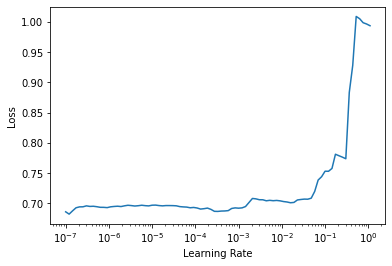

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.565938,0.721418,0.643239,0.798137,0.389985,02:48


Better model found at epoch 0 with valid_loss value: 0.7214182019233704.


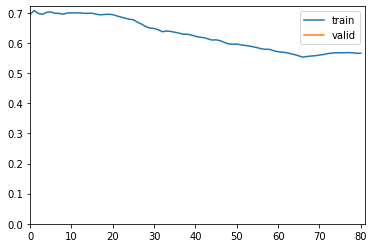

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.443210,0.549615,0.705118,0.897959,0.467375,02:42
1,0.423993,0.431121,0.769290,0.895787,0.613050,02:42
2,0.415667,0.773756,0.725745,0.655602,0.959029,02:41
3,0.398677,0.342401,0.810542,0.850085,0.757208,02:40
4,0.376504,0.361388,0.809778,0.866071,0.735964,02:40
5,0.351139,0.368524,0.815890,0.819572,0.813354,02:39
6,0.324579,0.375764,0.805195,0.854386,0.738998,02:40


Better model found at epoch 0 with valid_loss value: 0.5496149659156799.


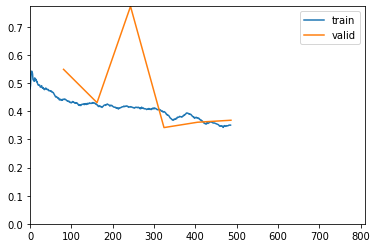

Better model found at epoch 1 with valid_loss value: 0.43112096190452576.
Better model found at epoch 3 with valid_loss value: 0.34240099787712097.
No improvement since epoch 3: early stopping


In [11]:
learn.fine_tune(10,base_lr=1e-3)

In [12]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

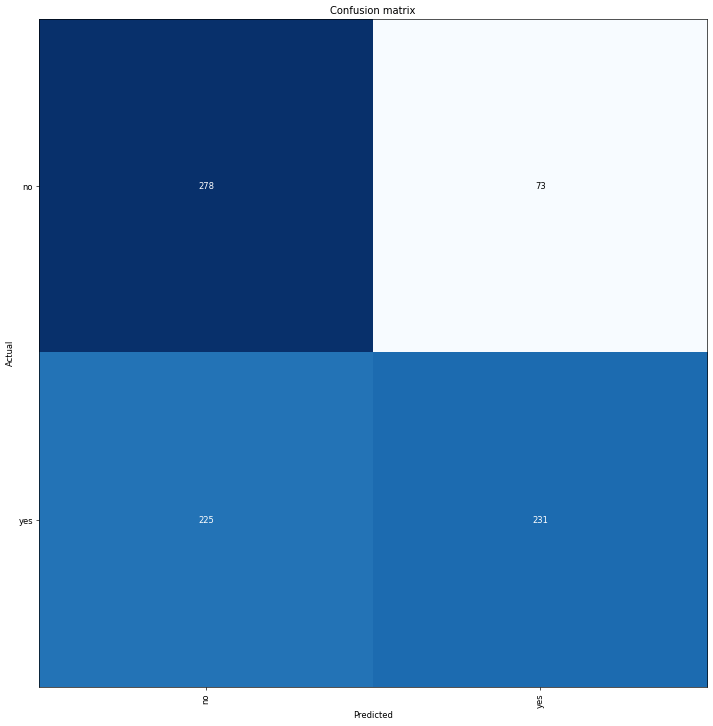

In [13]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [14]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6307311058044434.


(#4) [0.6561751365661621,0.6307311058044434,0.7598684210526315,0.506578947368421]

In [15]:
learn.export(fname='Hrnet44.pkl')